<a href="https://colab.research.google.com/github/quincylin1/mmocr-1/blob/mmocr_issue/MMOCR%20Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMOCR Tutorial

Welcome to MMOCR! This is the official colab tutorial for using MMOCR. In this tutorial, you will learn

    Perform inference with a MMOCR detector.
    Train a detector with a toy dataset and visualize the results.

Let's start!

In [ ]:
# First, always check your nvcc and gcc compiler version!
!nvcc -V
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



## Install MMOCR

In [1]:
# Install dependencies: (use cu101 since colab has CUDA 10.1)
!pip install -U torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# Install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.5.0/index.html

# Install mmdetection
!pip install mmdet==2.11.0

# Install mmocr
!git clone https://github.com/open-mmlab/mmocr.git
%cd mmocr
!pip install -r requirements.txt
!pip install -v -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 27kB/s 
     |████████████████████████████████| 6.6MB 63.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.5.0/index.html
     |████████████████████████████████| 27.5MB 98kB/s 
     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 563kB 8.4MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=8f7f32ac424877286a2a738b2bbfff54cfdb7d9b723640b80e78e228d02721de
  St

## Perform Inference with MMOCR Detector
We now demonstrate how to perform inference with the MMOCR detector. As a starting point, we will train on the toy dataset for the SAR text recognition model and visualize the predictions. Text detection and other downstream tasks such as KIE follow similar procedures. 

In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(mmcv.__version__)
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check mmocr installation
import mmocr
print(mmocr.__version__)

1.5.0+cu101 True
2.11.0
1.3.2
10.1
GCC 7.3
0.1.0


### Train a Text Recognizer on a Toy Dataset

To demonstrate the usage of MMOCR detector, we first give an example of how to perform inference on a toy dataset for the SAR text recognition model on colab. After you have familiarized yourself with the basics of training, testing as well as visualizing results, you will be on good grounds to perform inference on the extensive academic datasets that we provide in [MMOCR documentation](https://mmocr.readthedocs.io/en/latest/index.html). 

Training a dataset usually consists of the following steps:
1. Convert the dataset into a format supported by MMOCR (e.g. COCO for text detection). The annotation file can be in either .txt or .lmdb format, depending on the size of the dataset. This step is usually applicable to customized datasets, since the datasets and annotation files we provide are already in supported formats. 
2. Modify the config for training. 
3. Train the model. 

The toy dataset consisits of ten images as well as annotation files in both txt and lmdb format, which can be found in [ocr_toy_dataset](.github/tests/data/ocr_toy_dataset). 



### Convert Dataset into Supported Format

The ocr toy dataset is already in supported format. 

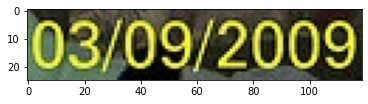

In [ ]:
# Visualize the toy dataset
import mmcv
import matplotlib.pyplot as plt 

img = mmcv.imread('./tests/data/ocr_toy_dataset/imgs/1036169.jpg')
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# Inspect the labels of the annootation file
!cat tests/data/ocr_toy_dataset/label.txt

1223731.jpg GRAND
1223733.jpg HOTEL
1223732.jpg HOTEL
1223729.jpg PACIFIC
1036169.jpg 03/09/2009
1190237.jpg ANING
1058891.jpg Virgin
1058892.jpg america
1240078.jpg ATTACK
1210236.jpg DAVIDSON


### Modify the Configuration File

In order to perform inference for SAR on colab, we need to modify the config file to accommodate some of the settings of colab such as the number of GPU available. 

In [ ]:
from mmcv import Config
cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py')

In [ ]:
from mmdet.apis import set_random_seed

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 20

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=12)
log_config = dict(interval=20, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[3, 4], warmup=None)
total_

Register the OCRDataset type in dataset so that it can be supported by MMOCR.

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmocr.core.evaluation.ocr_metric import eval_ocr_metric
from mmocr.datasets.base_dataset import BaseDataset


@DATASETS.register_module()
class OCRDataset(BaseDataset):

    def pre_pipeline(self, results):
        results['img_prefix'] = self.img_prefix
        results['text'] = results['img_info']['text']

    def evaluate(self, results, metric='acc', logger=None, **kwargs):
        """Evaluate the dataset.
        Args:
            results (list): Testing results of the dataset.
            metric (str | list[str]): Metrics to be evaluated.
            logger (logging.Logger | str | None): Logger used for printing
                related information during evaluation. Default: None.
        Returns:
            dict[str: float]
        """
        gt_texts = []
        pred_texts = []
        for i in range(len(self)):
            item_info = self.data_infos[i]
            text = item_info['text']
            gt_texts.append(text)
            pred_texts.append(results[i]['text'])

        eval_results = eval_ocr_metric(pred_texts, gt_texts)

        return eval_results


KeyError: ignored

### Train the SAR Text Recognizer 
Next, we train the SAR text recognizer on the toy dataset for five epochs. 

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/mmdet/apis/train.py:97: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
2021-04-29 01:27:05,315 - mmdet - INFO - Start running, host: root@aa20bf8c0889, work_dir: /content/mmocr/tutorial_exps
2021-04-29 01:27:05,317 - mmdet - INFO - workflow: [('train', 1)], max: 5 epochs
2021-04-29 01:27:12,430 - mmdet - INFO - Epoch [1][20/125]	lr: 1.250e-04, eta: 0:03:33, time: 0.354, data_time: 0.107, memory: 2683, loss_ce: 3.5109, loss: 3.5109
2021-04-29 01:27:17,334 - mmdet - INFO - Epoch [1][40/125]	lr: 1.250e-04, eta: 0:02:55, time: 0.245, data_time: 0.003, memory: 2683, loss_ce: 2.1188, loss: 2.1188
2021-04-29 01:27:22,257 - mmdet - INFO - Epoch [1][60/125]	lr: 1.250e-04, eta: 0:02:39, time: 0.246, data_time: 0.003, memory: 2683, loss_ce: 1.5326, loss: 1.5326
2021-04-29 01:27:27,201 - mmdet - INFO - Epoch [1][80/125]	lr: 1.250e-04, eta: 0:02:28, time:

In [ ]:
# Create an outputs file to save the prediction outputs
!mkdir outputs

In [ ]:
!ls

build	 docs	  mmocr.egg-info   requirements      setup.py
configs  INFO	  outputs	   requirements.txt  tests
demo	 LICENSE  README.md	   resources	     tools
docker	 mmocr	  README_zh-CN.md  setup.cfg	     tutorial_exps


### Test and Visualize the Predictions

Perform testing on the latest checkpoint and evaluate the results with hmean-iou metrics. The predictions are saved in the ./outputs file. 

In [ ]:
!python ./tools/test.py ./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py tutorial_exps/epoch_5.pth --eval hmean-iou --show-dir outputs

Use load_from_local loader
[>>] 10/10, 7.2 task/s, elapsed: 1s, ETA:     0s
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
{'0_word_acc': 1.0, '0_word_acc_ignore_case': 1.0, '0_word_acc_ignore_case_symbol': 1.0, '0_char_recall': 1.0, '0_char_precision': 1.0, '0_1-N.E.D': 1.0}


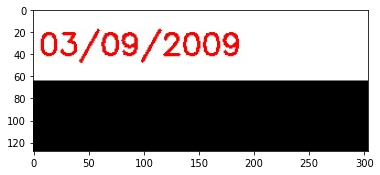

In [ ]:
# Visualize the results
predicted_img = mmcv.imread('./outputs/1036169.jpg')
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()



We can train and test an academic dataset for text detection and KIE in a manner similar to text recognition for toy dataset. Training an academic dataset is extremely time-consuming to be implemented on colab, and thus we refer readers to [getting_started.md](.github/docs/getting_started.md) for the specific implementation process. Here, we only demonstrate how to perform testing on an academic dataset by downloading checkpoints from MMOCR documentation. 

### Testing for Text Detection

Here, we demonstrate how to visualize the bounding box results predicted by the PANet model for the demo text detection image provided in [demo_text_det.jpg](.github/demo/demo_text_det.jpg). 

In [14]:
!python demo/image_demo.py demo/demo_text_det.jpg configs/textdet/panet/panet_r18_fpem_ffm_600e_icdar2015.py https://download.openmmlab.com/mmocr/textdet/panet/panet_r18_fpem_ffm_sbn_600e_icdar2015_20210219-42dbe46a.pth outputs/demo_text_det_pred.jpg

Use load_from_http loader
/usr/local/lib/python3.7/dist-packages/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
result: {'boundary_result': [[814.189567565918, 39.13043260574341, 814.189567565918, 0.0, 904.2201447486877, 0.0, 904.2201447486877, 39.13043260574341, 0.905051052570343], [125.25993347167969, 70.43477869033813, 90.03057718276978, 70.43477869033813, 90.03057718276978, 46.95651912689209, 125.25993347167969, 46.95651912689209, 0.9709924459457397], [547.689794005928, 90.27621306043739, 487.5236017727184, 85.64961081325555, 489.6650210712687, 57.8209596063175, 549.8311834401829, 62.44756185349934, 0.9715930223464966], [364.0366816520691, 105.6521680355072, 364.0366816520691, 86.0869517326355, 395.351665019989, 86.0869517326355, 395.351665019989, 105.6521680355072, 0

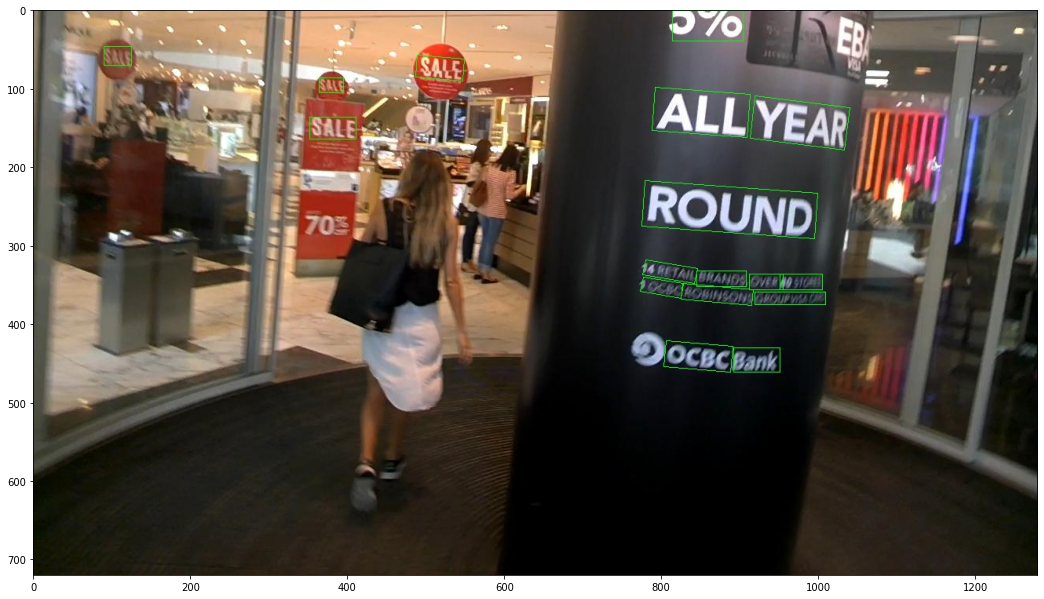

In [13]:
# Visualize the results
import matplotlib.pyplot as plt
predicted_img = mmcv.imread('./outputs/demo_text_det_pred.jpg')
plt.figure(figsize=(18, 32))
plt.imshow(mmcv.bgr2rgb(predicted_img))
plt.show()

### Testing for KIE

We perform testing on the SDMGR dataset by first downloading the KIE .tar file from [Datasets Preparation](https://mmocr.readthedocs.io/en/latest/datasets.html) in MMOCR documentation. We have chosen the Visual + Textual moduality test dataset, which we evaluate with Macro F1 metrics.

In [ ]:
# First download the KIE dataset .tar file and extract it to ./data
%cd /content/mmocr
!mkdir data
!wget https://download.openmmlab.com/mmocr/data/wildreceipt.tar
!tar -xf wildreceipt.tar 
!mv wildreceipt ./data

/content/mmocr
--2021-04-29 13:15:06--  https://download.openmmlab.com/mmocr/data/wildreceipt.tar
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.78
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185323520 (177M) [application/x-tar]
Saving to: ‘wildreceipt.tar’

wildreceipt.tar     100%[===================>] 176.74M  13.4MB/s    in 13s     

2021-04-29 13:15:20 (13.3 MB/s) - ‘wildreceipt.tar’ saved [185323520/185323520]



In [ ]:
# Test the dataset with macro f1 metrics 
!python tools/test.py configs/kie/sdmgr/sdmgr_unet16_60e_wildreceipt.py https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210405-16a47642.pth --eval macro_f1

Use load_from_http loader
Downloading: "https://download.openmmlab.com/mmocr/kie/sdmgr/sdmgr_unet16_60e_wildreceipt_20210405-16a47642.pth" to /root/.cache/torch/checkpoints/sdmgr_unet16_60e_wildreceipt_20210405-16a47642.pth
100% 18.4M/18.4M [00:01<00:00, 11.6MB/s]
[>>] 472/472, 14.3 task/s, elapsed: 33s, ETA:     0s{'macro_f1': 0.87641114}
